In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [53]:
df = pd.read_csv('../data/posts_combined_text.csv').drop(columns=['author_fullname', 'created_utc'])
df.head()

,title,selftext,subreddit,prolife_or_not,selftext_impute,all_text
0,Jake here thinks we use abortion as a girls ni...,NaN,prochoice,0,,Jake here thinks we use abortion as a girls ni...
1,How Black Feminists Defined Abortion Rights—As...,NaN,prochoice,0,,How Black Feminists Defined Abortion Rights—As...
2,US-linked anti-abortion centre targeting women...,NaN,prochoice,0,,US-linked anti-abortion centre targeting women...
3,I catch myself sometimes looking for the proli...,Anyone else ever do that? I think *Pfb* (pro f...,prochoice,0,Anyone else ever do that? I think *Pfb* (pro f...,I catch myself sometimes looking for the proli...
4,France extends abortion limit to 14 weeks,NaN,prochoice,0,,France extends abortion limit to 14 weeks


In [57]:
# Baseline accuracy:
df[['prolife_or_not']].value_counts(normalize=True)

prolife_or_not
0                 0.500701
1                 0.499299
dtype: float64

# Logistic regression models

### Features: only vectorization

In [3]:
X = df['all_text']
y = df['prolife_or_not']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 29)

In [10]:
pipe = Pipeline([
    ('cv', CountVectorizer()),
    ('logreg', LogisticRegression(max_iter=1000))
])

params = {
    'cv__stop_words': [None, ['png', 'https', 'http', 'www']],
    'cv__max_features': [750, 1000, 1500],
    'cv__ngram_range': [(1,1), (1,2), (1,3)],
    'cv__binary': [True, False]
    'cv__strip_accents': [True, False]
}

gs = GridSearchCV(pipe, param_grid = params)
gs.fit(X_train, y_train)
print(gs.best_params_)
gs.score(X_train, y_train), gs.score(X_test, y_test)

{'cv__binary': True, 'cv__max_features': 1000, 'cv__ngram_range': (1, 3), 'cv__stop_words': None}


(0.7292028308185339, 0.6299559471365639)

### Features: add sentiment analysis

In [ ]:
X = df[['all_text']]
y = df['prolife_or_not']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29)

In [59]:
# Transformers

# Functions for vectorization
def extract_series(df):
    return df['all_text']
extract_series_tf = FunctionTransformer(extract_series, validate=False)

def sparse_to_array(sparse):
    return sparse.toarray() #https://stackoverflow.com/questions/26576524/how-do-i-transform-a-scipy-sparse-matrix-to-a-numpy-matrix
sparse_to_array_tf = FunctionTransformer(sparse_to_array, validate=False)

# Pipeline for vectorization
pipe_cv = Pipeline([
    # text as pandas series
    ('extract_series', extract_series_tf),
    # vectorizer
    ('cv', CountVectorizer()),
    # sparse output to np array
    ('sparse_to_array', sparse_to_array_tf)
])

# Function for sentiment extraction
def compound_sentiment_from_doc(text):
    sia = SentimentIntensityAnalyzer()
    return sia.polarity_scores(text)['compound']

def compound_sentiment_from_corpus(df):
    return df['all_text'].map(compound_sentiment_from_doc).to_frame().values #returns np array, 2d
compound_sentiment_tf = FunctionTransformer(compound_sentiment_from_corpus, validate=False)


# feature union combines np arrays output by each transformer
feature_union = FeatureUnion([
    ('pipe_cv', pipe_cv),
    ('compound_sentiment', compound_sentiment_tf)
])

In [ ]:
# Pipeline with feature union, logistic regression model
pipe_union_logreg = Pipeline([
    ('feature_union', feature_union),
    ('ss', StandardScaler()),
    ('logreg', LogisticRegression(max_iter = 1200))
])

params = {
#  'feature_union__pipe_cv__cv__stop_words': [None, 'english', ['http', 'www', 'png'],
   'feature_union__pipe_cv__cv__max_features': [7000]
}

gs_union_logreg = GridSearchCV(pipe_union_logreg, param_grid = params)
gs_union_logreg.fit(X_train, y_train)
print(gs_union_logreg.best_score_)
gs_union_logreg.best_params_

# Decision tree models

### Features: only vectorization

In [68]:
X = df['all_text']
y = df['prolife_or_not']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=29)

In [44]:
pipe_tree = Pipeline([
    ('cv', CountVectorizer()),
    ('tree', DecisionTreeClassifier(min_samples_split=3))
])

tree_params = {
    'cv__max_features': [9000, 12000, 15000],
    'cv__stop_words': [None, 'english'],
    'cv__ngram_range': [(1,1), (1,2), (1,3)],
}

gs_tree = GridSearchCV(pipe_tree, param_grid = tree_params)
gs_tree.fit(X_train, y_train)
print(gs_tree.best_score_)


0.6226455581389748


AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [46]:
gs_tree.best_params_

{'cv__max_features': 12000,
 'cv__ngram_range': (1, 3),
 'cv__stop_words': 'english'}

In [58]:
gs_tree.score(X_test, y_test)

0.6267521025230276

In [65]:
import sklearn.metrics as metrics

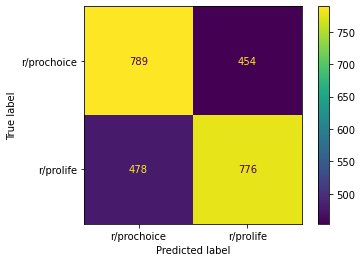

In [73]:
metrics.plot_confusion_matrix(gs_tree, X_test, y_test, values_format='d', display_labels=['r/prochoice', 'r/prolife']);
plt.savefig('../figures/confusion_matrix.png')

In [76]:
preds = gs_tree.predict(X_test)

print(f'recall: {metrics.recall_score(y_test, preds)}')
print(f'precision: {metrics.precision_score(y_test, preds)}')
specificity = 789/ (789 + 454)
print(f'specificity: {specificity}')

recall: 0.6188197767145136
precision: 0.6308943089430894
specificity: 0.6347546259050684


### Features: add sentiment analysis

In [62]:
# Pipeline w/ feature union, decision tree

pipe_union_tree = Pipeline([
    ('feature_union', feature_union),
    ('decision_tree', DecisionTreeClassifier(min_samples_leaf=3, random_state=29))
])
    
gs_tree_params = {
    'feature_union__pipe_cv__cv__stop_words': [None, 'english'],
    'feature_union__pipe_cv__cv__ngram_range': [(1,1), (1,2), (1,3)],
    #'decision_tree__max_depth': [50, 100],
  #  'decision_tree__ccp_alpha': [.1, .3, .5]   
}

gs_union_tree = GridSearchCV(pipe_union_tree, param_grid = gs_tree_params)
gs_union_tree.fit(X_train, y_train)
print(gs_union_tree.best_score_)
gs_union_tree.best_params_

KeyboardInterrupt: 

### TF-IDF as alternative to CountVectorizer

In [14]:
# Pipeline for vectorization
pipe_tfidf = Pipeline([
    # text as pandas series
    ('extract_series', extract_series_tf),
    # vectorizer
    ('tfidf', TfidfVectorizer()),
    # sparse output to np array
    ('sparse_to_array', sparse_to_array_tf)
])

# feature union 
feature_union_tfidf = FeatureUnion([
    ('pipe_tfidf', pipe_tfidf),
    ('compound_sentiment', compound_sentiment_tf)
])

# Pipeline feature union, decision tree
pipe_tfidf = Pipeline([
    ('feature_union_tfidf', feature_union_tfidf),
    ('decision_tree', DecisionTreeClassifier())
])

# Gridsearch
tfidf_tree_params = {}

gs_tfidf = GridSearchCV(pipe_tfidf, param_grid=tfidf_tree_params)
gs_tfidf.fit(X_train, y_train)
print(gs_tfidf.best_score_)
gs_tfidf.best_params_

0.6015480895034395


{}

In [15]:
gs_tfidf.score(X_test, y_test)

0.5963155786944333